In [1]:
import pprint
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ORBIT import ProjectManager, SupplyChainManager, load_config
from ORBIT.supply_chain import DEFAULT_MULTIPLIERS, LABOR_SPLIT, TURBINE_CAPEX_SPLIT
from supply_chain_plots import waterfall_plot, area_time_plot

pp = pprint.PrettyPrinter(indent=4)


In [2]:
# These are from the spreadsheet on teams
# They can be overridden in ORBIT/supply_chain.py or passed as a new dict
# into the manager class like SupplyChainManager(supply_chain, multipliers={different multipliers})
pp.pprint(DEFAULT_MULTIPLIERS)

{   'array_cable': {'domestic': 0.19, 'imported': 0.0},
    'blades': {'domestic': 0.026, 'imported': 0.3},
    'export_cable': {'domestic': 0.231, 'imported': 0.0},
    'monopile': {'domestic': 0.085, 'imported': 0.28, 'tariffs': 0.25},
    'nacelle': {'domestic': 0.025, 'imported': 0.1},
    'oss_substructure': {'domestic': 0.0, 'imported': 0.0},
    'oss_topside': {'domestic': 0.0, 'imported': 0.0},
    'tower': {'domestic': 0.04, 'imported': 0.2, 'tariffs': 0.25},
    'transition_piece': {'domestic': 0.169, 'imported': 0.17, 'tariffs': 0.25}}


In [3]:
# These are used for the tariff calculations: tariffs = (1 - labor_split) * total_cost * tariff_rate
# % of cost that is labor vs material
pp.pprint(LABOR_SPLIT)

{'monopile': 0.5, 'oss_topside': 0.5, 'tower': 0.5, 'transition_piece': 0.5}


In [4]:
# Load Sample Config
config = load_config("supply_chain_project.yaml")  
capacity = config['plant']['num_turbines'] * int(config['turbine'].split('M')[0]) * 1000


In [5]:
# Define supply chain scenario to use
# Options are imported, domestic or domestic, imported steel
supply_chain_scenarios = {
    2023: {
    "blades": "imported",
    "nacelle": "imported",
    "tower": "imported",
    "monopile": "imported",
    "transition_piece": "imported",
    "array_cable": "imported",
    "export_cable": "imported",
    "oss_topside": "imported"
},
    2025: {
    "blades": "domestic",
    "nacelle": "imported",
    "tower": "domestic, imported steel",
    "monopile": "domestic, imported steel",
    "transition_piece": "domestic, imported steel",
    "array_cable": "imported",
    "export_cable": "imported",
    "oss_topside": "domestic"       
    },
    2027: {
    "blades": "domestic",
    "nacelle": "domestic",
    "tower": "domestic, imported steel",
    "monopile": "domestic",
    "transition_piece": "domestic, imported steel",
    "array_cable": "domestic",
    "export_cable": "domestic",
    "oss_topside": "domestic"       
    },
    2030: {
    "blades": "domestic",
    "nacelle": "domestic",
    "tower": "domestic",
    "monopile": "domestic",
    "transition_piece": "domestic",
    "array_cable": "domestic",
    "export_cable": "domestic",
    "oss_topside": "domestic"      
    },
}

a = 'test'
years = []
scenarios = []
cost_breakdown = {
    'Wind turbine': [],
    'Substructure': [],
    'Electrical infrastructure': [],
}
total_capex = []

opex = 110
fcr = .058
ncf = .489
lcoe = []

for k,v in supply_chain_scenarios.items():
    years.append(k)  # list of ints
    _v = SupplyChainManager(v)
    _sc_project= _v.run_project(config)
    cost_breakdown['Wind turbine'].append(_sc_project.capex_breakdown['Turbine'] / capacity) # Nacelle, blades, tower
    cost_breakdown['Substructure'].append(_sc_project.capex_breakdown['Substructure']/ capacity)  # Monopile, TP
    cost_breakdown['Electrical infrastructure'].append(_sc_project.capex_breakdown['Array System'] / capacity +
                                                       _sc_project.capex_breakdown['Export System'] / capacity +
                                                       _sc_project.capex_breakdown['Offshore Substation'] / capacity
                                                      )  # Array cables, export cables, OSS
    total_capex.append(_sc_project.total_capex / capacity)
    lcoe.append(1000* (fcr * _sc_project.total_capex_per_kw + opex) / (8760 * ncf) )


ORBIT library intialized at 'C:\Users\mshields\Documents\Analysis tools\ORBIT\library'


In [6]:
# Create some summary statistics
cost_breakdown_perc = {
    'Wind turbine': [],
    'Substructure': [],
    'Electrical infrastructure': [],
}
for k, v in cost_breakdown.items():
    perc = [100*(i/v[0] -1) for n,i in enumerate(v)]
    cost_breakdown_perc[k] = perc 
print(cost_breakdown_perc)

total_capex_perc = [100*(i/total_capex[0] - 1) for n,i in enumerate(total_capex)] 
print(total_capex)

lcoe_perc = [100*(i/lcoe[0] - 1) for n,i in enumerate(lcoe)] 
print(lcoe_perc)

{'Wind turbine': [0.0, -5.71753158229571, -7.585204035263082, -7.585204035263082], 'Substructure': [0.0, 0.22892079711949176, -6.073632329891055, -9.862292156751318], 'Electrical infrastructure': [0.0, 0.0, 11.239304468294996, 11.239304468294996]}
[3525.171189529579, 3444.7533606745355, 3419.073942596618, 3395.439070922778]
[0.0, -1.4832522822647354, -1.9568917228414917, -2.3928208924097305]


In [7]:
#Calculte baseline costs with no premiums
base_project = ProjectManager(config)
base_project.run()
base_capex = (base_project.capex_breakdown['Turbine'] + 
              base_project.capex_breakdown['Substructure'] + 
              base_project.capex_breakdown['Array System'] +            
              base_project.capex_breakdown['Export System']+
              base_project.capex_breakdown['Offshore Substation'] ) / capacity
print(base_capex)

2163.834546663371


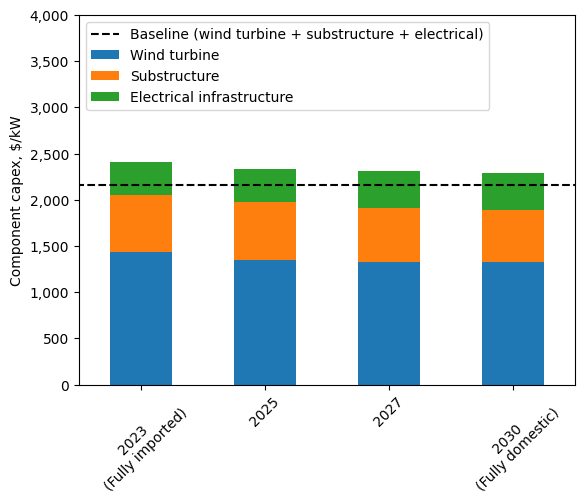

In [8]:
years[0] = str(years[0]) + ' \n(Fully imported)'
years[-1] = str(years[-1]) + '\n(Fully domestic)'

fig = plt.figure()
ax = fig.add_subplot()
df = pd.DataFrame(cost_breakdown, index=years)
df.plot.bar(stacked=True, rot=45, ax=ax)

ax.plot([-5,5], [base_capex, base_capex], 'k--', label='Baseline (wind turbine + substructure + electrical)')

# Formatting
ax.set_ylim([0,4000])
ax.set_ylabel('Component capex, $/kW')
# ax.set_xlabel('Commercial operation date')
ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend(loc='upper left')

# SAve fig
fig_dir = 'C:/Users/mshields/Documents/Projects/Supply Chain Roadmap/Analysis repos/LCOE/results'
fname_bar = '/capex_barchart.png'
fig.savefig(fig_dir+fname_bar, dpi=300, bbox_inches='tight')


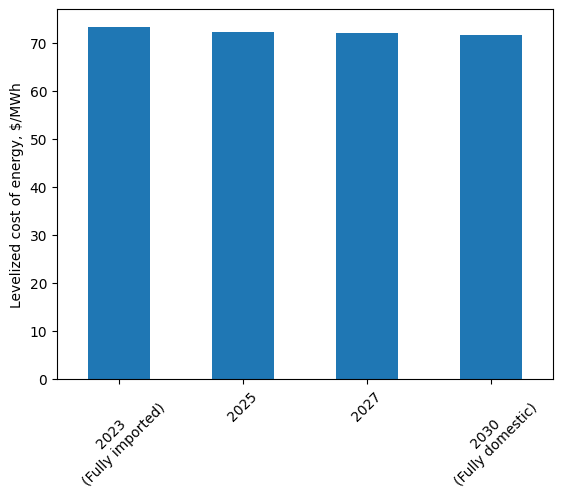

In [9]:
dict_lcoe = {'LCOE': lcoe}
# for y, l in zip(years, lcoe):
#     print(y,l)
#     dict_lcoe[y] = l

df_lcoe = pd.DataFrame(dict_lcoe, index=years)
fig = plt.figure()
ax = fig.add_subplot()
df_lcoe.plot.bar(rot=45, ax=ax)

# Formatting
ax.get_legend().remove()
ax.set_ylabel('Levelized cost of energy, $/MWh')

# SAve fig
fig_dir = 'C:/Users/mshields/Documents/Projects/Supply Chain Roadmap/Analysis repos/LCOE/results'
fname_lcoe = '/lcoe_barchart.png'
fig.savefig(fig_dir+fname_lcoe, dpi=300, bbox_inches='tight')

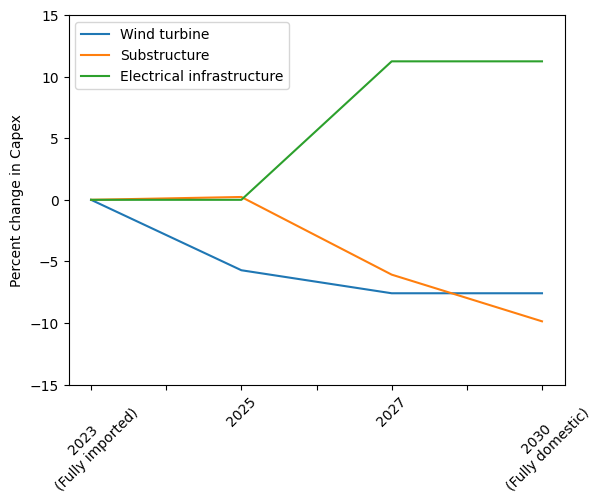

In [10]:
df_perc = pd.DataFrame(cost_breakdown_perc, index=years)

fig = plt.figure()
ax = fig.add_subplot()
df_perc.plot(rot=45, ax=ax)

# Formatting
ax.set_ylim([-15, 15])
ax.set_ylabel('Percent change in Capex')
# ax.set_xlabel('Commercial operation date')
ax.legend(loc='upper left')

#
fname_perc = '/percent_change.png'
fig.savefig(fig_dir+fname_perc, dpi=300, bbox_inches='tight')

## Taking a crack at a waterfall

In [11]:
european_cost = base_capex 
multiplier_structure = {'Turbine': ['blades', 'nacelle', 'tower'],
                       'Substructure': ['monopile', 'transition_piece'],
                       'Array System': ['array_cable'],
                       'Export System': ['export_cable'],}

transit_cost = {}
factory_cost = {}
total_transit_cost = 0
total_factory_cost = 0

for k,v in multiplier_structure.items():
    print(k,v)
    transit_cost[k] = 0
    factory_cost[k] = 0
    for vi in v:
        if k == 'Turbine':
            split =  TURBINE_CAPEX_SPLIT[vi]
        else:
            split = 1
        _transit = base_project.capex_breakdown_per_kw[k] * split * DEFAULT_MULTIPLIERS[vi]['imported']
        _factory = base_project.capex_breakdown_per_kw[k] * split * DEFAULT_MULTIPLIERS[vi]['domestic']
        transit_cost[k] += _transit
        factory_cost[k] += _factory
        total_transit_cost += _transit
        total_factory_cost += _factory

print(base_project.capex_breakdown_per_kw['Turbine'], transit_cost, factory_cost, total_transit_cost, total_factory_cost)

Turbine ['blades', 'nacelle', 'tower']
Substructure ['monopile', 'transition_piece']
Array System ['array_cable']
Export System ['export_cable']
1301.0 {'Turbine': 130.49030000000002, 'Substructure': 226.62796945399697, 'Array System': 0.0, 'Export System': 0.0} {'Turbine': 21.90884, 'Substructure': 127.91889831403384, 'Array System': 19.955383985464, 'Export System': 20.41809} 357.11826945399696 190.20121229949785


In [12]:
# Plot waterfall
european = base_capex + total_transit_cost

slack =   total_transit_cost - total_factory_cost

domestic = european

transit_perc = '-' + str(round(100*total_transit_cost / base_capex, 2)) + '%'
factory_perc = str(round(100*total_factory_cost / base_capex, 2) ) + '%'
slack_perc = str(round(100*slack / base_capex, 2)) + '%'

x = ['Imported', 'Transit', 'Factory', 'Margin', 'Domestic']
y = [european, total_transit_cost, total_factory_cost, slack,  domestic]
bottom = [0, european-total_transit_cost, european-total_transit_cost, european-total_transit_cost + total_factory_cost, 0]
color = ['#5E6A71', '#8CC63F', '#933C06', '#FFC423', '#5E6A71']
bar_text = {'transit': transit_perc, 'factory': factory_perc, 'margin': slack_perc}

fdir = 'C:/Users/mshields/Documents/Projects/Supply Chain Roadmap/Analysis repos/LCOE/results/'
fname = 'lcoe_waterfall'

fnamedir = fdir + fname

waterfall_plot(x, y, bottom, color, bar_text, fname=fnamedir)

### Plot an area chart over time

In [13]:
x = [2023, 2025, 2027, 2030]
color_list = {'Wind turbine': '#5E6A71', 'Substructure': '#D9531E', 'Electrical infrastructure': '#5D9732', 'Cost margin': '#00A4E4'}

fdir = 'C:/Users/mshields/Documents/Projects/Supply Chain Roadmap/Analysis repos/LCOE/results/'
fname = 'capex_area'

fnamedir = fdir + fname

area_time_plot(x, cost_breakdown, color_list, fname=fnamedir)

FixedFormatter should only be used together with FixedLocator

### Old methods below

In [14]:
# Run a project through this method
# It will perform the supply chain adjustments and return a project instance with the adjusted values
sc_project = sc_manager.run_project(config)


NameError: name 'sc_manager' is not defined

In [ ]:
# This is just for comparison
project = ProjectManager(config)
project.run()
print(project.capex_breakdown_per_kw)
print('blades', .135 * project.capex_breakdown_per_kw['Turbine'])
print('nacelle', .274 * project.capex_breakdown_per_kw['Turbine'])
print('tower', .162 * project.capex_breakdown_per_kw['Turbine'])

install_costs = 0
for c,v in project.capex_breakdown_per_kw.items():
    if 'Installation' in c:
        install_costs += v
    else:
        pass
# print(project.capex_breakdown_per_kw)
print(install_costs)
print(project.total_capex_per_kw)

In [ ]:
3274 - (175.6+356.5+210.8+503.6+88.4+105+165+313.5+252.1+543.1)

In [ ]:
# Comparing the values from SupplyChainManager vs. ProjectManager
df = pd.concat([
    pd.Series(project.capex_breakdown, name="ORBIT"),
    pd.Series(sc_project.capex_breakdown, name="SupplyChain")
], axis=1)

df["Ratio"] = df["SupplyChain"] / df["ORBIT"]

In [ ]:
df